### Import Modules and Data

In [253]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [254]:
df_ger = pd.read_csv("data/preprocessed_survey_results_encoded.csv")

### Helper Functions


In [255]:
def calc_scores(estimators, x_test, y_test) -> (list, list, list, list, list):
    """
    Calculates the scores from multiple estimators. For example of cross validations.

    :param estimators: list of estimators
    :param x_test: x test split
    :param y_test: y test split
    :return: quadruple of list of the scores
    """
    r2_scores = []
    mae_scores =  []
    mape_scores = []
    rmse_scores = []
    max_scores = []
    for estimator in estimators:
        predictions = estimator.predict(x_test)
        r2_scores.append(metrics.r2_score(y_test, predictions))
        mae_scores.append(metrics.mean_absolute_error(y_test, predictions))
        mape_scores.append(metrics.mean_absolute_percentage_error(y_test, predictions))
        rmse_scores.append(np.sqrt(metrics.mean_squared_error(y_test, predictions)))
        max_scores.append(metrics.max_error(y_test, predictions))

    return r2_scores, mae_scores, mape_scores, rmse_scores, max_scores

## Regression

### Data Prep

In [256]:
# selected_features = ['YearsCode', 'Age', 'OrgSize', 'in-person', 'remote']
selected_features = ['YearsCode', 'OrgSize', 'Age','Bachelor’s degree', 'Doctoral degree', 'Master’s degree','Primary school', 'Professional degree', 'Secondary school','University courses', 'in-person', 'remote', 'APL', 'Assembly','Bash/Shell', 'C', 'C#', 'C++', 'COBOL', 'Clojure', 'Crystal', 'Dart','Delphi', 'Elixir', 'Erlang', 'F#', 'Fortran', 'Go', 'Groovy','HTML/CSS', 'Haskell', 'Java', 'JavaScript', 'Julia', 'Kotlin', 'LISP','Lua', 'MATLAB', 'OCaml', 'Objective-C', 'PHP', 'Perl', 'PowerShell','Python', 'R', 'Ruby', 'Rust', 'SAS', 'SQL', 'Scala', 'Solidity','Swift', 'TypeScript', 'VBA']

x = df_ger[selected_features]
y = df_ger['Salary']

scaler = MinMaxScaler(feature_range=(0,1))
# scaler = StandardScaler()
scaler.fit(x)
x = pd.DataFrame(scaler.transform(x), index=x.index, columns=x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)
folds = KFold(n_splits=10, shuffle=True, random_state=100)

### Linear Regression

R2:   0.187
MAE:  14145
MAPE: 0.206
RMSE: 18301
MAX:  69530


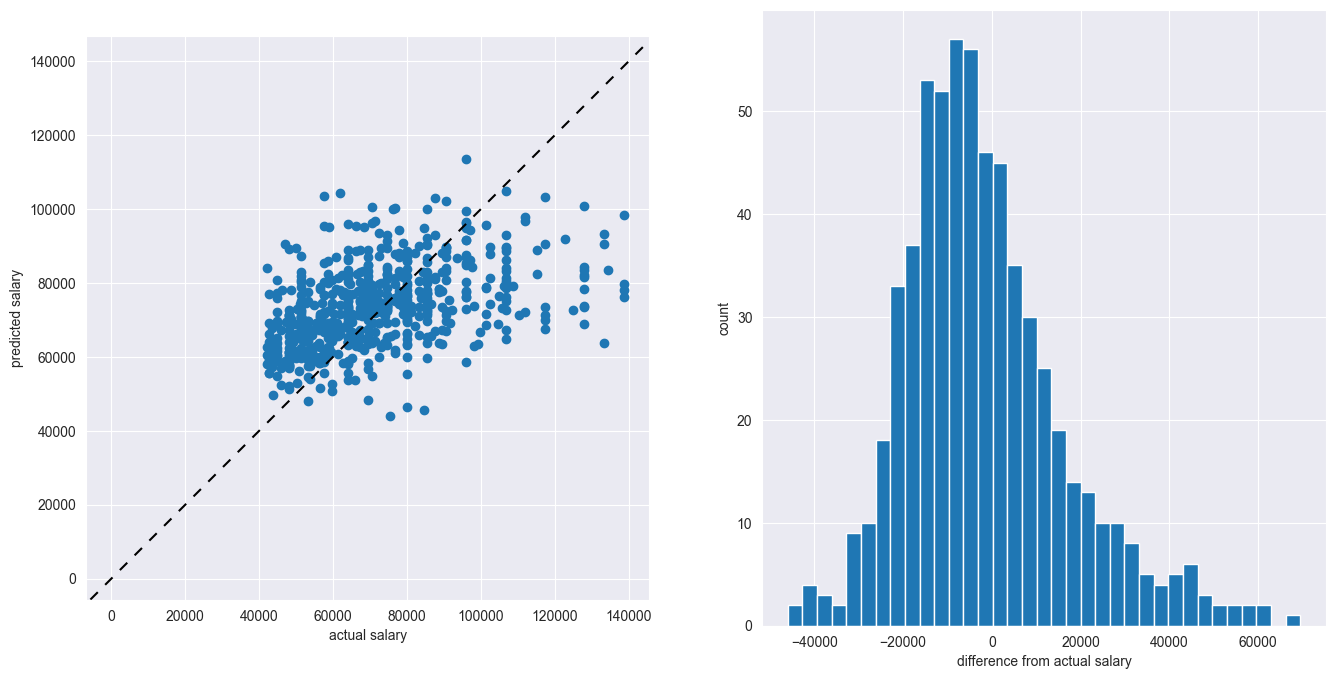

In [257]:
lm = LinearRegression()
lm.fit(x_train, y_train)
prediction_linear = lm.predict(x_test)

r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores([lm], x_test, y_test)
print('R2:  ', np.round(np.mean(r2_scores), 3))
print('MAE: ', np.mean(mae_scores).astype(int))
print('MAPE:', np.round(np.mean(mape_scores), 3))
print('RMSE:', np.mean(rmse_scores).astype(int))
print('MAX: ', np.max(max_scores).astype(int))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].scatter(x=y_test, y=prediction_linear)
axs[0].axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
axs[0].axis('square')
axs[0].set(xlabel="actual salary", ylabel="predicted salary")
axs[1].set(xlabel="difference from actual salary", ylabel="count")
axs[1].hist((y_test-prediction_linear), bins=35)
plt.show()

In [258]:
lm_cv = LinearRegression()
estimators = cross_validate(lm_cv, x_train, y_train, cv=folds, return_estimator=True)['estimator']
r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores(estimators, x_test, y_test)
print('R2   (cross validated):', np.round(np.mean(r2_scores), 3))
print('MAE  (cross validated):', np.mean(mae_scores).astype(int))
print('MAPE (cross validated):', np.round(np.mean(mape_scores), 3))
print('RMSE (cross validated):', np.mean(rmse_scores).astype(int))
print('MAX  (cross validated):', np.max(max_scores).astype(int))
print('\nR2   (splits):', np.round(r2_scores, 3))
print('MAE  (splits):', list(map(round, mae_scores)))
print('MAPE (splits):', np.round(mape_scores, 3))
print('RMSE (splits):', list(map(round, rmse_scores)))
print('MAX  (splits):', list(map(round, max_scores)))

R2   (cross validated): -3.317204252044335e+23
MAE  (cross validated): -2147483648
MAPE (cross validated): 3459137493.948
RMSE (cross validated): -2147483648
MAX  (cross validated): -2147483648

R2   (splits): [ 1.80000000e-01  1.84000000e-01  1.81000000e-01  1.80000000e-01
  1.76000000e-01 -3.22963018e+24  1.88000000e-01 -8.75740768e+22
  1.79000000e-01  1.85000000e-01]
MAE  (splits): [14222, 14151, 14196, 14227, 14248, 2530890548539986, 14164, 340282113276533, 14221, 14154]
MAPE (splits): [2.07000000e-01 2.06000000e-01 2.08000000e-01 2.08000000e-01
 2.08000000e-01 2.88861891e+10 2.06000000e-01 5.70518579e+09
 2.08000000e-01 2.06000000e-01]
RMSE (splits): [18378, 18336, 18364, 18375, 18421, 36471763239749616, 18287, 6005762401467601, 18391, 18321]
MAX  (splits): [69816, 67901, 66354, 70592, 66399, 525581603910571648, 70746, 105997878281274416, 72552, 70623]


C:\Users\jonas\AppData\Local\Temp\ipykernel_10100\1937093519.py:5: RuntimeWarning: invalid value encountered in cast
  print('MAE  (cross validated):', np.mean(mae_scores).astype(int))
C:\Users\jonas\AppData\Local\Temp\ipykernel_10100\1937093519.py:7: RuntimeWarning: invalid value encountered in cast
  print('RMSE (cross validated):', np.mean(rmse_scores).astype(int))
C:\Users\jonas\AppData\Local\Temp\ipykernel_10100\1937093519.py:8: RuntimeWarning: invalid value encountered in cast
  print('MAX  (cross validated):', np.max(max_scores).astype(int))


### Random Forest Regressor

R2:   0.114
MAE:  14826
MAPE: 0.217
RMSE: 19099
MAX:  63280


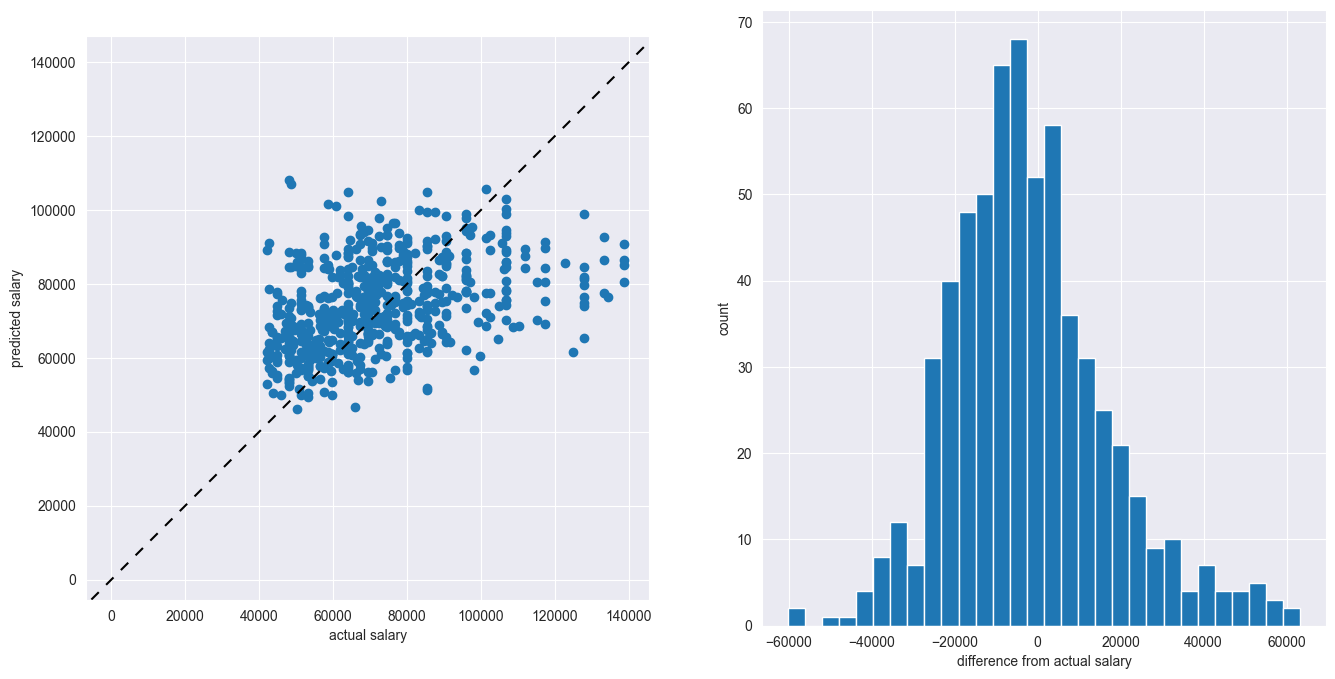

In [259]:
random_regressor = RandomForestRegressor(random_state=1, bootstrap=True)
random_regressor.fit(x_train, y_train)
prediction_rf = random_regressor.predict(x_test)

r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores([random_regressor], x_test, y_test)
print('R2:  ', np.round(np.mean(r2_scores), 3))
print('MAE: ', np.mean(mae_scores).astype(int))
print('MAPE:', np.round(np.mean(mape_scores), 3))
print('RMSE:', np.mean(rmse_scores).astype(int))
print('MAX: ', np.max(max_scores).astype(int))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].scatter(x=y_test, y=prediction_rf)
axs[0].axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
axs[0].axis('square')
axs[0].set(xlabel="actual salary", ylabel="predicted salary")
axs[1].set(xlabel="difference from actual salary", ylabel="count")
axs[1].hist((y_test-prediction_rf), bins=30)
plt.show()

### Gradient Boosting Regressor

R2:   0.184
MAE:  14220
MAPE: 0.207
RMSE: 18335
MAX:  67928


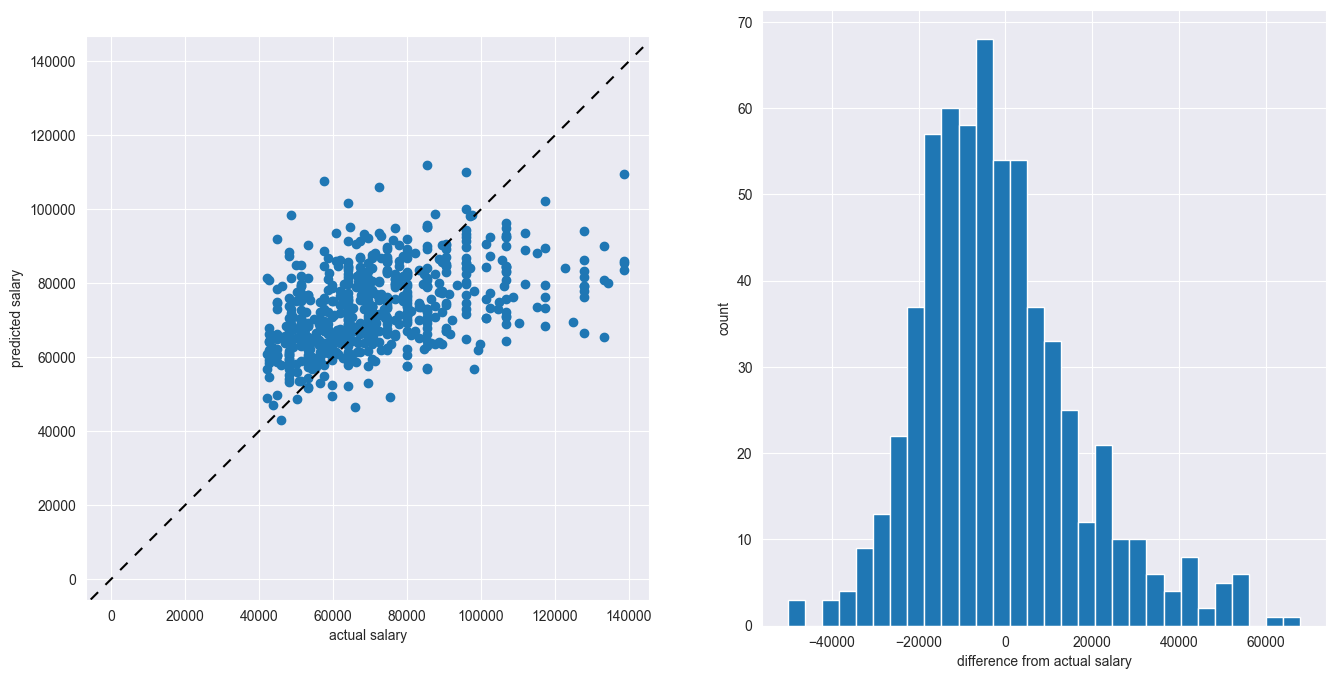

In [260]:
gbt_regressor = GradientBoostingRegressor(random_state=1)
gbt_regressor.fit(x_train, y_train)
prediction_gbt = gbt_regressor.predict(x_test)

r2_scores, mae_scores, mape_scores, rmse_scores, max_scores = calc_scores([gbt_regressor], x_test, y_test)
print('R2:  ', np.round(np.mean(r2_scores), 3))
print('MAE: ', np.mean(mae_scores).astype(int))
print('MAPE:', np.round(np.mean(mape_scores), 3))
print('RMSE:', np.mean(rmse_scores).astype(int))
print('MAX: ', np.max(max_scores).astype(int))

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].scatter(x=y_test, y=prediction_gbt)
axs[0].axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
axs[0].axis('square')
axs[0].set(xlabel="actual salary", ylabel="predicted salary")
axs[1].set(xlabel="difference from actual salary", ylabel="count")
axs[1].hist((y_test-prediction_gbt), bins=30)
plt.show()

## Analyse coefficients

In [261]:
df_coeff = pd.DataFrame()
df_coeff['coeff'] = lm.coef_
df_coeff['feature'] = selected_features
df_coeff['coeff_abs'] = np.abs(lm.coef_)
df_coeff.sort_values(by='coeff_abs', ascending=False)

,coeff,feature,coeff_abs
0,29964.568538,YearsCode,29964.568538
2,16114.406801,Age,16114.406801
25,15365.190061,F#,15365.190061
20,-13794.471654,Crystal,13794.471654
1,12504.569431,OrgSize,12504.569431
19,11439.801088,Clojure,11439.801088
26,-10034.823239,Fortran,10034.823239
38,9395.912989,OCaml,9395.912989
24,9345.686684,Erlang,9345.686684
47,9333.498077,SAS,9333.498077


In [262]:
df_ger[df_ger['OCaml'] == 1]

,Unnamed: 0,Salary,YearsCode,YearsCodePro,OrgSize,Age,Gender,Bachelor’s degree,Doctoral degree,Master’s degree,...,R,Ruby,Rust,SAS,SQL,Scala,Solidity,Swift,TypeScript,VBA
73,2381,108777.0,19.0,15.0,5.0,5.0,Man,1,0,0,...,0,0,1,0,0,1,0,0,0,0
442,13695,127972.0,25.0,20.0,5.0,5.0,Man,0,0,1,...,0,0,1,0,0,0,0,0,0,0
795,28168,53322.0,25.0,15.0,3.0,4.0,Man,0,0,1,...,0,1,0,0,1,0,0,0,0,1
896,30612,61402.0,11.0,4.0,4.0,3.0,Man,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [263]:
df_ger[df_ger['Fortran'] == 1]

,Unnamed: 0,Salary,YearsCode,YearsCodePro,OrgSize,Age,Gender,Bachelor’s degree,Doctoral degree,Master’s degree,...,R,Ruby,Rust,SAS,SQL,Scala,Solidity,Swift,TypeScript,VBA
67,2282,95979.0,20.0,8.0,7.0,3.0,Man,0,0,1,...,0,0,1,0,1,0,0,0,1,0
144,5041,57588.0,20.0,16.0,4.0,5.0,Man,0,0,1,...,1,0,0,0,1,0,0,0,0,1
183,5761,74651.0,45.0,32.0,5.0,6.0,Man,0,0,1,...,0,1,0,0,0,0,0,0,0,0
595,19223,74651.0,20.0,14.0,5.0,4.0,Man,0,0,1,...,1,0,0,0,0,0,0,0,0,0
789,27721,95979.0,33.0,22.0,3.0,4.0,Man,0,0,0,...,0,1,0,0,1,1,0,0,0,0
1471,51030,63984.0,40.0,30.0,7.0,6.0,Man,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1646,57433,74651.0,25.0,21.0,5.0,4.0,Man,0,1,0,...,0,1,1,0,1,0,0,1,1,0
1944,68177,95979.0,23.0,11.0,8.0,4.0,Man,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1950,68431,89581.0,30.0,30.0,6.0,5.0,Man,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1955,68662,51189.0,20.0,14.0,5.0,4.0,Man,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [264]:
df_ger[df_ger['Erlang'] == 1]

,Unnamed: 0,Salary,YearsCode,YearsCodePro,OrgSize,Age,Gender,Bachelor’s degree,Doctoral degree,Master’s degree,...,R,Ruby,Rust,SAS,SQL,Scala,Solidity,Swift,TypeScript,VBA
82,2667,63984.0,25.0,20.0,4.0,4.0,Man,0,0,0,...,0,0,0,0,1,0,0,0,1,0
317,8727,43512.0,13.0,3.0,6.0,3.0,Other,1,0,0,...,0,0,1,0,1,0,0,0,0,1
370,10421,74651.0,15.0,7.0,2.0,3.0,Man,0,0,0,...,0,0,0,0,0,0,0,0,1,0
584,19034,102372.0,25.0,25.0,1.0,4.0,Other,0,0,1,...,0,1,0,0,1,0,0,0,1,0
603,19384,71984.0,15.0,13.0,4.0,4.0,Man,0,0,0,...,0,0,1,0,1,0,0,0,1,0
697,23250,99179.0,19.0,15.0,7.0,3.0,Man,1,0,0,...,0,1,0,0,1,0,0,0,0,0
729,24597,106644.0,26.0,24.0,6.0,4.0,Man,1,0,0,...,0,0,0,0,0,0,0,0,0,0
774,26830,90007.0,10.0,8.0,7.0,3.0,Man,0,0,0,...,0,1,1,0,1,0,0,0,0,0
789,27721,95979.0,33.0,22.0,3.0,4.0,Man,0,0,0,...,0,1,0,0,1,1,0,0,0,0
790,28019,90647.0,8.0,8.0,7.0,3.0,Man,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [265]:
df_ger[df_ger['Solidity'] == 1]

,Unnamed: 0,Salary,YearsCode,YearsCodePro,OrgSize,Age,Gender,Bachelor’s degree,Doctoral degree,Master’s degree,...,R,Ruby,Rust,SAS,SQL,Scala,Solidity,Swift,TypeScript,VBA
236,6937,71451.0,7.0,6.0,2.0,4.0,Man,0,0,0,...,0,0,0,0,1,0,1,0,1,0
847,29293,51189.0,16.0,10.0,2.0,6.0,Man,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1046,35630,53322.0,5.0,2.0,5.0,2.0,Woman,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1474,51169,51192.0,7.0,3.0,2.0,2.0,Man,0,0,0,...,0,0,0,1,1,0,1,0,0,0
1873,65237,74651.0,15.0,12.0,2.0,3.0,Man,0,0,0,...,0,0,0,0,1,0,1,0,1,0
